In [4]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import MinMaxScaler
import pickle

np.random.seed(29)


In [5]:
# Scales each feature to lie in [0, 1] and separate the data into training and
# test sets.

def preprocess_data(X, y):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    return [X_train, X_test, y_train, y_test]
    
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [10]:
dataset_names = ['wdbc', 'arrhythmia','DARWIN','CIFAR100']
dataset_arrays = []

data = pd.read_csv('breast+cancer+wisconsin+diagnostic/wdbc.data', header=None).to_numpy()
X = data[:, 2:31]
y = data[:, 1]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)


data = pd.read_csv('arrhythmia/arrhythmia.data', header=None).replace('?', np.nan).to_numpy()
# Fills in missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imputer.fit_transform(data)
X = data[:, 0:278]
y = data[:, 279]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

data = pd.read_csv('DARWIN/data.csv', header=None).replace('?',np.nan).to_numpy()
X=data[1:,1:451]
y=data[1:,451]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

data=unpickle("cifar-10-batches-py/data_batch_1")
X=data.get(b"data")
y=data.get(b"labels")
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

# Returns the dataset with given name
def get_dataset(name):
    i = dataset_names.index(name)
    return dataset_arrays[i]

In [64]:
class Models():

    def __init__(self, modelName, maxIter, L2, nEstimators, bagging, modelTitle):
        """
        modelName: dataset to use
        maxIter: max iterations to train to
        L2: array of L2 regularization, None if no L2 reg.
        nEstimators: array of nEstimators, None if not doing Ensemble
        bagging: Fraction we want to test, None if no bagging
        modelTitle: Title for graphs, what is this model?
        """
        self.modelName=modelName
        self.XTrain,self.XTest,self.yTrain,self.yTest=get_dataset(modelName)
        self.maxIter=maxIter
        self.L2=L2
        self.nEstimators=nEstimators
        self.bagging=bagging
        self.modelTitle=modelTitle
        self.modelResults={}

    def NEst(self, numEst):

        if self.bagging==None:
            return {"Bagging:None":self.BagFrac(None,numEst)}
        else:
            returnDic={}
            returnDic["Bagging:None"]=self.BagFrac(None,numEst)
            for frac in self.bagging:
                returnDic[f"Bagging:{frac}"]=self.BagFrac(frac,numEst)
        return returnDic

    def BagFrac(self, bagfrac,numEst):
        if self.L2==None:
            return {"L2:None":self.L2Reg(None,bagfrac,numEst)}
        else:
            returnDic={}
            returnDic["L2:None"]=self.L2Reg(None,bagfrac,numEst)
            for l2 in self.L2:
                returnDic[f"L2:{l2}"]=self.L2Reg(l2,bagfrac,numEst)
        return returnDic

    def L2Reg(self, l2,bagFrac,numEst):
        if l2==None:
            base = LogisticRegression(penalty=None, max_iter=self.maxIter)
        else:
            base=LogisticRegression(penalty='l2', C=l2, max_iter=self.maxIter)
        if bagFrac==None and numEst==None:
            base.fit(self.XTrain,self.yTrain)
            return {"tr":base.score(self.XTrain, self.yTrain),
                "te":base.score(self.XTest, self.yTest)}
        elif bagFrac==None and numEst != None:
            classifier=BaggingClassifier(estimator=base, 
                                           n_estimators=numEst, 
                                           max_samples=1.0)

            classifier.fit(self.XTrain, self.yTrain)
            return {"tr":classifier.score(self.XTrain, self.yTrain),
                "te":classifier.score(self.XTest, self.yTest)}
        elif bagFrac != None and numEst == None:
            classifier=BaggingClassifier(estimator=base, 
                                           n_estimators=1, 
                                           max_samples=bagFrac)

            classifier.fit(self.XTrain, self.yTrain)
            return {"tr":classifier.score(self.XTrain, self.yTrain),
                "te":classifier.score(self.XTest, self.yTest)}
        else:
            bagging_classifier = BaggingClassifier(estimator=base, 
                                           n_estimators=numEst, 
                                           max_samples=bagFrac)
            bagging_classifier.fit(self.XTrain, self.yTrain)
            return {"tr":bagging_classifier.score(self.XTrain, self.yTrain),
                "te":bagging_classifier.score(self.XTest, self.yTest)}

    def Train(self):
        """Does logical regression on data, returns training accuracy and test acc.
        can ignore output, saved to obj."""
        self.modelResults["NEst:None"]=self.NEst(None)
        if self.nEstimators!=None:
            for est in self.nEstimators:
                self.modelResults[f"NEst:{est}"]=self.NEst(est)

    def Graph(self,xaxis,include):
        """xAxis can be: NEST, L2, BAG
        include: NEST, L2, BAG, None; but not what was chosen as xaxis.[]
        """
        includeL2=False
        includeBAG=False
        includeNEST=False
        if "L2" in include:
            includeL2=True
        if "BAG" in include:
            includeBAG=True
        if "NEST" in include:
            includeNEST=True
        tr=[]
        te=[]
        ax=plt.gca()
        if xaxis=="NEST":
            if includeNEST:
                print("ERROR: xaxis cannot be the same as include")
                return None
            elif includeL2 and includeBAG:
                for bag in self.bagging:
                    for l2 in self.L2:
                        tr=[]
                        te=[]
                        for nEst in self.nEstimators:
                            tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                            te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                        colour = next(ax._get_lines.prop_cycler)['color']
                        plt.plot(self.nEstimators,tr,label=f"Train w/ Bag:{bag} L2:{l2}",linestyle="--",color=colour)
                        plt.plot(self.nEstimators,te,label=f"Test w/ Bag:{bag} L2:{l2}",linestyle="-",color=colour)
            elif includeL2:
                for l2 in self.L2:
                    tr=[]
                    te=[]
                    for nEst in self.nEstimators:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.nEstimators,tr,label=f"Train w/ Bag:None L2:{l2}",linestyle="--",color=colour)
                    plt.plot(self.nEstimators,te,label=f"Test w/ Bag:None L2:{l2}",linestyle="-",color=colour)
            elif includeBAG:
                for bagFrac in self.bagging:
                    tr=[]
                    te=[]
                    for nEst in self.nEstimators:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bagFrac}").get(f"L2:None").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bagFrac}").get(f"L2:None").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.nEstimators,tr,label=f"Train w/ Bag:{bagFrac} L2:None",linestyle="--",color=colour)
                    plt.plot(self.nEstimators,te,label=f"Test w/ Bag:{bagFrac} L2:None",linestyle="-",color=colour)
            else:
                pass

            #Plot None lines
            tr_OneEst=np.full(len(self.nEstimators), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("tr"))
            te_OneEst=np.full(len(self.nEstimators), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("te"))
            colour = next(ax._get_lines.prop_cycler)['color']
            plt.plot(self.nEstimators,tr_OneEst,label="Train w/o Bagging, L2, NumEst",linestyle="--",color=colour)
            plt.plot(self.nEstimators,te_OneEst,label="Test w/o Bagging, L2, NumEst",linestyle="-",color=colour)
        elif xaxis=="L2":
            if includeL2:
                print("ERROR: xaxis cannot be the same as include")
                return None
            elif includeNEST and includeBAG:
                for bag in self.bagging:
                    for nEst in self.nEstimators:
                        tr=[]
                        te=[]
                        for l2 in self.L2:
                            tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                            te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                        colour = next(ax._get_lines.prop_cycler)['color']
                        plt.plot(self.L2,tr,label=f"Train w/ Bag:{bag} nEst:{nEst}",linestyle="--",color=colour)
                        plt.plot(self.L2,te,label=f"Test w/ Bag:{bag} nEst:{nEst}",linestyle="-",color=colour)
            elif includeNEST:
                for nEst in self.nEstimators:
                    tr=[]
                    te=[]
                    for l2 in self.L2:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.L2,tr,label=f"Train w/ Bag:None nEst:{nEst}",linestyle="--",color=colour)
                    plt.plot(self.L2,te,label=f"Test w/ Bag:None nEst:{nEst}",linestyle="-",color=colour)
            elif includeBAG:
                for bag in self.bagging:
                    tr=[]
                    te=[]
                    for l2 in self.L2:
                        tr.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.L2,tr,label=f"Train w/ Bag:{bag} nEst:None",linestyle="--",color=colour)
                    plt.plot(self.L2,te,label=f"Test w/ Bag:{bag} nEst:None",linestyle="-",color=colour)
            else:
                pass

            #Plot None lines
            tr_OneEst=np.full(len(self.L2), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("tr"))
            te_OneEst=np.full(len(self.L2), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("te"))
            colour = next(ax._get_lines.prop_cycler)['color']
            plt.plot(self.L2,tr_OneEst,label="Train w/o Bagging, L2, NumEst",linestyle="--",color=colour)
            plt.plot(self.L2,te_OneEst,label="Test w/o Bagging, L2, NumEst",linestyle="-",color=colour)

        elif xaxis=="BAG":
            if includeBAG:
                print("ERROR: xaxis cannot be the same as include")
            elif includeL2 and includeNEST:
                for nEst in self.nEstimators:
                    for l2 in self.L2:
                        tr=[]
                        te=[]
                        for bag in self.bagging:
                            tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                            te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                        colour = next(ax._get_lines.prop_cycler)['color']
                        plt.plot(self.bagging,tr,label=f"Train w/ nEst:{nEst} L2:{l2}",linestyle="--",color=colour)
                        plt.plot(self.bagging,te,label=f"Test w/ nEst:{nEst} L2:{l2}",linestyle="-",color=colour)
            elif includeL2:
                for l2 in self.L2:
                    tr=[]
                    te=[]
                    for bag in self.bagging:
                        tr.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.bagging,tr,label=f"Train w/ nEst:None L2:{l2}",linestyle="--",color=colour)
                    plt.plot(self.bagging,te,label=f"Test w/ nEst:None L2:{l2}",linestyle="-",color=colour)
            elif includeNEST:
                for nEst in self.nEstimators:
                    tr=[]
                    te=[]
                    for bag in self.bagging:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:None").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:None").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.bagging,tr,label=f"Train w/ nEst:{nEst} L2:None",linestyle="--",color=colour)
                    plt.plot(self.bagging,te,label=f"Test w/ nEst:{nEst} L2:None",linestyle="-",color=colour)
            else:
                pass
        else:
            print("ERROR: incorrect xaxis value given")
        plt.legend(loc="best")
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(f"{self.modelTitle} comparing {xaxis} to Acc w/ {include}")
        plt.xlabel(xaxis)
        plt.ylabel("Accuracy")
        plt.show()




In [71]:
testModel=Models('wdbc',5000,[0.1,0.5,1,5,10,50,500],[10,20,40,80,160],[0.2,0.35,0.5,0.75,1],"Test of wdbc")
testModel.Train()

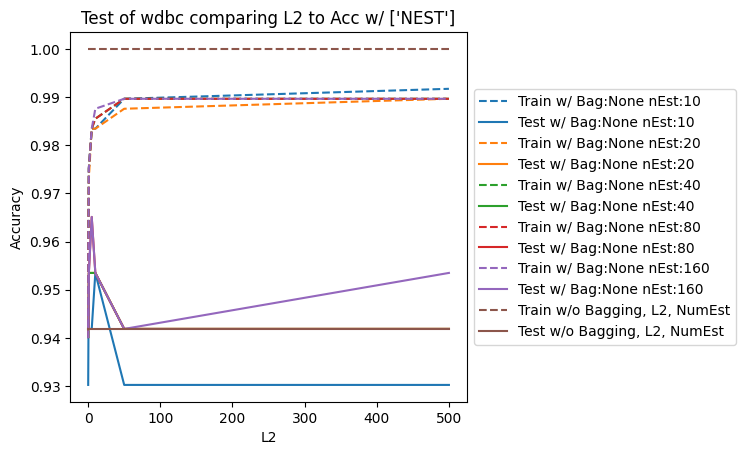

In [85]:
testModel.Graph('L2',["NEST"])







Previous Code

In [76]:
# Trains bagging model on top of logistic regression.
def bagging_log_regr(X_train, X_test, y_train, y_test, num_models, frac_samples, regularization=None):
    if (regularization == None):
        base = LogisticRegression(penalty=None, max_iter=5000)
    else:
        base = LogisticRegression(penalty='l2', C=regularization, max_iter=5000)
    bagging_classifier = BaggingClassifier(estimator=base, 
                                           n_estimators=num_models, 
                                           max_samples=frac_samples)
    bagging_classifier.fit(X_train, y_train)
    return bagging_classifier.score(X_train, y_train), bagging_classifier.score(X_test, y_test)

# Plots training and testing accuracy vs. number of base learners.
def plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_models, list_tr_acc, label='Train')
    plt.plot(list_n_models, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_models), nobag_tr_acc)
    nobag_te = np.full(len(list_n_models), nobag_te_acc)
    plt.plot(list_n_models, nobag_tr, label='Train without bagging')
    plt.plot(list_n_models, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()
    

1.0
0.9418604651162791
[0.9648033126293996, 0.9834368530020704, 0.9937888198757764, 0.989648033126294, 0.9917184265010351, 0.9917184265010351, 0.989648033126294]
[0.9418604651162791, 0.9302325581395349, 0.9534883720930233, 0.9418604651162791, 0.9418604651162791, 0.9418604651162791, 0.9418604651162791]


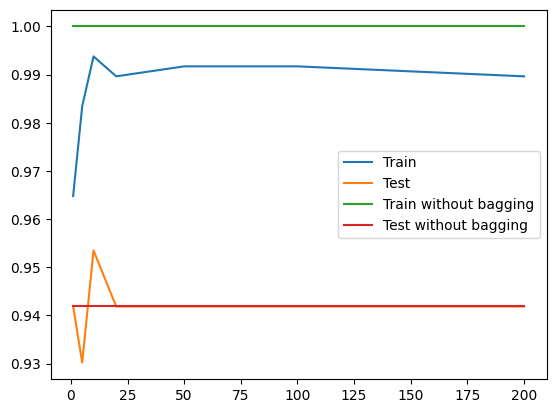

In [77]:
# Test on number of base learners

list_n_models = [1, 5, 10, 20, 50, 100, 200]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

1.0
0.6617647058823529
[0.78125, 0.8541666666666666, 0.859375, 0.8880208333333334, 0.9010416666666666, 0.8932291666666666, 0.8958333333333334]
[0.6029411764705882, 0.6176470588235294, 0.6323529411764706, 0.6617647058823529, 0.6470588235294118, 0.6617647058823529, 0.6470588235294118]


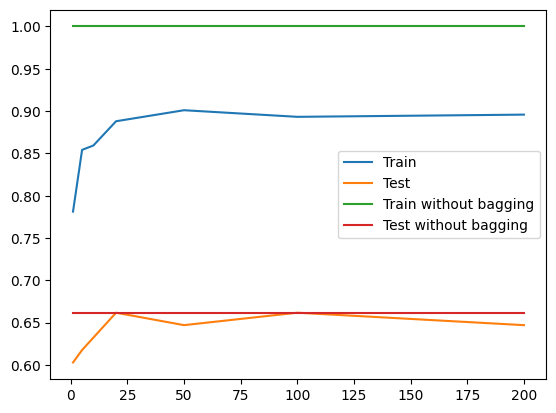

In [78]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)

list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)


In [79]:
# Plots training and test accuracies vs number of examples used to train each base learners.
def plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_examples, list_tr_acc, label='Train')
    plt.plot(list_n_examples, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_examples), nobag_tr_acc)
    nobag_te = np.full(len(list_n_examples), nobag_te_acc)
    plt.plot(list_n_examples, nobag_tr, label='Train without bagging')
    plt.plot(list_n_examples, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()

1.0
0.9418604651162791
[0.9834368530020704, 0.989648033126294, 0.989648033126294, 0.9917184265010351, 0.9958592132505176]
[0.9418604651162791, 0.9302325581395349, 0.9418604651162791, 0.9534883720930233, 0.9302325581395349]


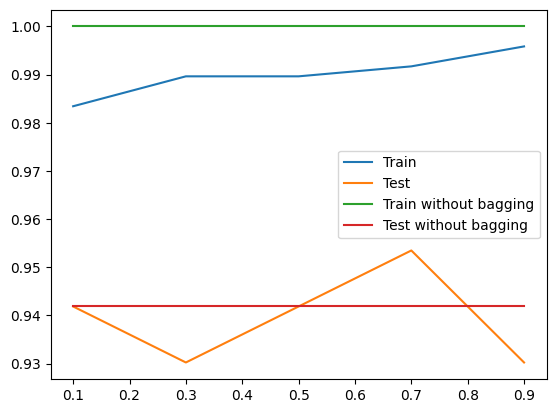

In [80]:
# Test on fraction of examples used to train each base learners

list_n_examples = [0.1, 0.3, 0.5, 0.7, 0.9]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_examples in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, n_examples)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

1.0
0.6617647058823529
[0.625, 0.7760416666666666, 0.8567708333333334, 0.9322916666666666, 0.9557291666666666]
[0.5735294117647058, 0.6176470588235294, 0.6323529411764706, 0.6470588235294118, 0.6470588235294118]


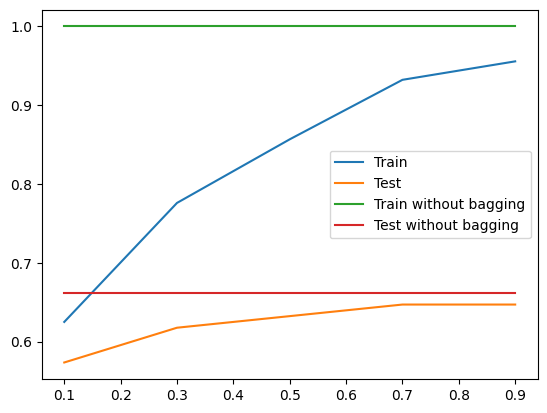

In [81]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_examples in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, n_examples)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

In [82]:
# Plots training and test accuracies vs C (inverse of regularization strength)
def plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc):
    plt.plot(list_C, list_tr_acc, label='Train w/ bagging')
    plt.plot(list_C, list_te_acc, label='Test w/ bagging')
    plt.plot(list_C, list_nobag_tr_acc, label='Train w/o bagging')
    plt.plot(list_C, list_nobag_te_acc, label='Test w/o bagging')
    plt.legend(loc='best')
    plt.show()

[0.9399585921325052, 0.9648033126293996, 0.9772256728778468, 0.9834368530020704, 0.9855072463768116, 0.989648033126294, 0.9917184265010351, 0.9875776397515528]
[0.9418604651162791, 0.9418604651162791, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9418604651162791, 0.9302325581395349, 0.9534883720930233]
[0.917184265010352, 0.9544513457556936, 0.9565217391304348, 0.9813664596273292, 0.9834368530020704, 0.9875776397515528, 0.9855072463768116, 0.9875776397515528]
[0.9069767441860465, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9418604651162791, 0.9302325581395349, 0.9186046511627907]


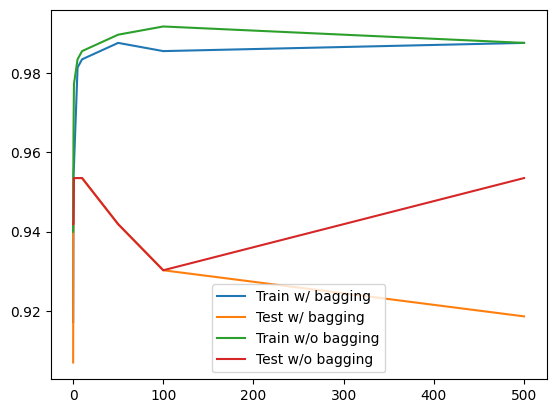

In [83]:
# Test on C

list_C = [0.1, 0.5, 1, 5, 10, 50, 100, 500]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

list_nobag_tr_acc = []
list_nobag_te_acc = []
list_tr_acc = []
list_te_acc = []
for C in list_C:
    log_regr = LogisticRegression(penalty='l2', C=C, max_iter=5000)
    log_regr.fit(X_train, y_train)
    list_nobag_tr_acc.append(log_regr.score(X_train, y_train))
    list_nobag_te_acc.append(log_regr.score(X_test, y_test))
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, 0.5, regularization=C)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_nobag_tr_acc)
print(list_nobag_te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc)

[0.6432291666666666, 0.7786458333333334, 0.8229166666666666, 0.9375, 0.9609375, 0.9921875, 1.0, 1.0]
[0.5441176470588235, 0.6323529411764706, 0.6617647058823529, 0.6617647058823529, 0.6764705882352942, 0.6764705882352942, 0.6617647058823529, 0.6617647058823529]
[0.5885416666666666, 0.7083333333333334, 0.7317708333333334, 0.8046875, 0.8098958333333334, 0.8333333333333334, 0.8854166666666666, 0.8671875]
[0.47058823529411764, 0.6029411764705882, 0.6176470588235294, 0.6323529411764706, 0.6617647058823529, 0.6764705882352942, 0.6470588235294118, 0.6470588235294118]


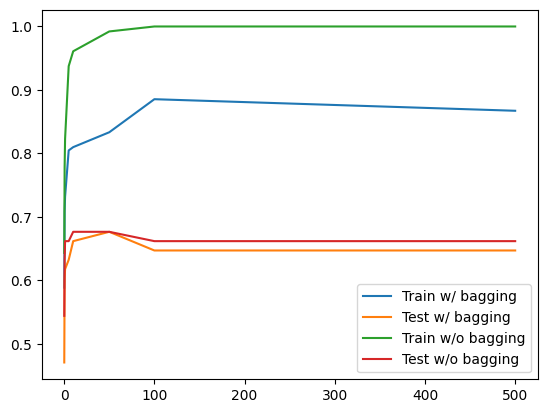

In [84]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

list_nobag_tr_acc = []
list_nobag_te_acc = []
list_tr_acc = []
list_te_acc = []
for C in list_C:
    log_regr = LogisticRegression(penalty='l2', C=C, max_iter=5000)
    log_regr.fit(X_train, y_train)
    list_nobag_tr_acc.append(log_regr.score(X_train, y_train))
    list_nobag_te_acc.append(log_regr.score(X_test, y_test))
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, 0.5, regularization=C)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_nobag_tr_acc)
print(list_nobag_te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc)